# WasteNet Image Classifier
Setup

In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from copy import copy
from PIL import Image
from tqdm import tqdm
import warnings
from pathlib import Path
import torchvision
import gc
import re
import os
from google.colab import drive, files

# mount drive
drive.mount('/content/drive') 

warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}.".format(device))

Using cuda.


In [ ]:
!unzip '/content/drive/MyDrive/cs160/data/Waste_Dataset.zip'
!rm -r '/content/__MACOSX'

In [4]:
data_path = '/content/Waste_Dataset'

# convert to png
for file in Path(data_path).glob('**/*.jpg'):
    file.rename(file.with_suffix('.png'))

Path('/content/drive/MyDrive/cs160').mkdir(parents=False, exist_ok=True)

In [5]:
mean, std = [0.6727, 0.6401, 0.6046], [0.2093, 0.2103, 0.2317]

train_transform = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(360, fill=255),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

val_transform = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset = datasets.ImageFolder(root=data_path + '/TRAIN', transform=train_transform)
val_dataset = datasets.ImageFolder(root=data_path + '/TEST', transform=val_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


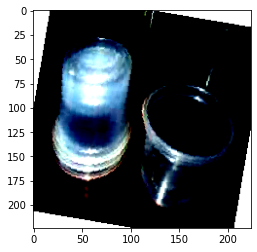

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


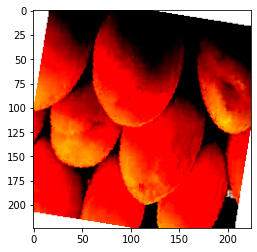

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


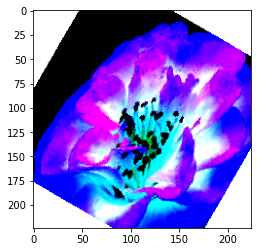

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


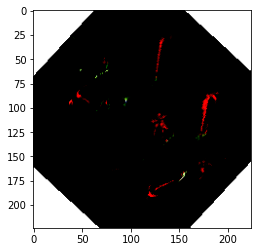

In [6]:
iter_sample = iter(DataLoader(train_dataset,
                              batch_size=1,
                              shuffle=True,
                              num_workers=4,
                              pin_memory=True))

view_img = [next(iter_sample) for _ in range(4)] 

fig = plt.figure()

# view images  
for x, idx in view_img:
    plt.imshow(x.squeeze(0).permute((1, 2, 0)))
    plt.show()

In [7]:
class WasteNet(nn.Module):
    def __init__(self, num_classes=2):
        super(WasteNet, self).__init__()
        pretrained = torchvision.models.vgg16_bn(pretrained=True)
        for layer in list(pretrained.children()):
            layer.requires_grad = False
        self.model = nn.Sequential(*list(pretrained.children())[:-1])
        self.classifier = nn.Sequential(nn.LazyLinear(4096, bias=True),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, num_classes))
        self.classifier.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x.flatten(1, -1))
        return x

In [35]:
lr = 1e-3
batch_size = 64
num_epoch = 8

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers = 8,
                          shuffle=True,
                          pin_memory=True)

model = WasteNet().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

loss_list, acc_list = [], []

model.train()
for epoch in range(num_epoch):
    correct = 0
    total_loss = 0
    tq = tqdm(train_loader, position=0, leave=True)
    tq.set_description("Epoch {}".format(epoch))
    for id, (img, target) in enumerate(tq, 0):
        img, target = img.to(device), target.to(device)
        output = model(img)
        
        optimizer.zero_grad()
        loss = loss_fn(output, target)
        preds = output.argmax(dim=1)
        correct += (preds == target).sum().item()
        total_loss += loss.item()
        acc = correct / (batch_size * (id + 1))
        loss.backward()
        optimizer.step()

        loss_list.append(total_loss / (id + 1))
        acc_list.append(acc)

        tq.set_postfix(loss=total_loss, accuracy=acc)
        # free up space for GPU
        del output, loss, preds
        gc.collect()
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_list,
                'accuracy' : acc_list
                }, '/content/drive/MyDrive/cs160/WasteNet.pth')      

Epoch 7: 100%|██████████| 353/353 [01:51<00:00,  3.16it/s, accuracy=0.898, loss=93.3]


In [ ]:
def plot_performance():
    losses = torch.load('/content/drive/MyDrive/cs160/WasteNet.pth')['loss']
    accuracies = torch.load('/content/drive/MyDrive/cs160/WasteNet.pth')['accuracy']

    fig = plt.figure(dpi=120)
    plt.plot(list(range(len(losses))), losses)
    plt.title('Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.xscale()
    plt.ylabel('Loss')
    plt.show()

    fig = plt.figure(dpi=120)
    plt.plot(list(range(len(accuracies))), accuracies)
    plt.title('Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    # losses, accuracies = [], []
    # for epoch in range(num_epoch):
plot_performance()

In [10]:
val_loader = DataLoader(val_dataset,
                        batch_size=1,
                        num_workers = 8,
                        shuffle=True,
                        pin_memory=True)

model = WasteNet().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cs160/WasteNet.pth')['model_state_dict'])
loss_fn = nn.CrossEntropyLoss()

correct = 0
total_loss = 0
tq = tqdm(val_loader, position=0, leave=True)

model.eval()
for id, (img, target) in enumerate(tq):
  img, target = img.to(device), target.to(device)
  output = model(img)
  loss = loss_fn(output, target)
  preds = output.argmax(dim=1)
  correct += (preds == target).sum().item()
  total_loss += loss.item()
  acc = correct / (id + 1)
  tq.set_postfix(loss=total_loss, accuracy=acc)

100%|██████████| 2513/2513 [00:25<00:00, 99.22it/s, accuracy=0.918, loss=566] 
